## Name: Saksham Jain
## Email: sakshamgr8online@gmail.com

In [1]:
import numpy as np 
import pandas as pd 
import os
import numpy as np
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
import seaborn as sns
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pratilipi-dataset/user_interaction.csv
/kaggle/input/pratilipi-dataset/metadata.csv


In [2]:
%matplotlib inline

In [3]:
indata= pd.read_csv("/kaggle/input/pratilipi-dataset/user_interaction.csv")

In [4]:
metadata = pd.read_csv("/kaggle/input/pratilipi-dataset/metadata.csv")

In [5]:
indata.head()

,user_id,pratilipi_id,read_percent,updated_at
0,5506791961876448,1377786228262109,100.0,2022-03-22 10:29:57.291
1,5506791971543560,1377786223038206,40.0,2022-03-19 13:49:25.660
2,5506791996468218,1377786227025240,100.0,2022-03-21 17:28:47.288
3,5506791978752866,1377786222398208,65.0,2022-03-21 07:39:25.183
4,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777


In [6]:
metadata.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


In [7]:
metadata.shape,indata.shape

((954501, 6), (2500000, 4))

In [8]:
metadata.columns,indata.columns

(Index(['author_id', 'pratilipi_id', 'category_name', 'reading_time',
        'updated_at', 'published_at'],
       dtype='object'),
 Index(['user_id', 'pratilipi_id', 'read_percent', 'updated_at'], dtype='object'))

## Visualization and Understanding Distributions across DataSet

In [9]:
# Frequency across categories
metadata["category_name"].value_counts()

romance                      193220
shortstories                 102097
social                        73920
suspense                      64041
family                        58515
novels                        53584
life                          51356
moral-inspiring               47421
women                         37168
horror                        28506
entertainment                 23362
action-and-adventure          21589
experiences-and-memories      20276
webseries                     16227
relegion-and-spiritual        15476
comedy                        14893
Pratilipi-kalamkar-samman     13237
mythology                     12324
children                      10196
Indiawale                      9674
Pratilipi-Awards-Hindi         9342
fantasy                        9324
swahindi2                      7853
drama                          7387
crime                          7151
politics                       5810
translation                    4250
short-story-challenge       

In [10]:
len(metadata["category_name"].value_counts())

45

In [11]:
metadata["category_name"] = metadata["category_name"].str.replace('-','')

In [12]:
# Fixing plot size
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

AxesSubplot(0.125,0.125;0.775x0.755)


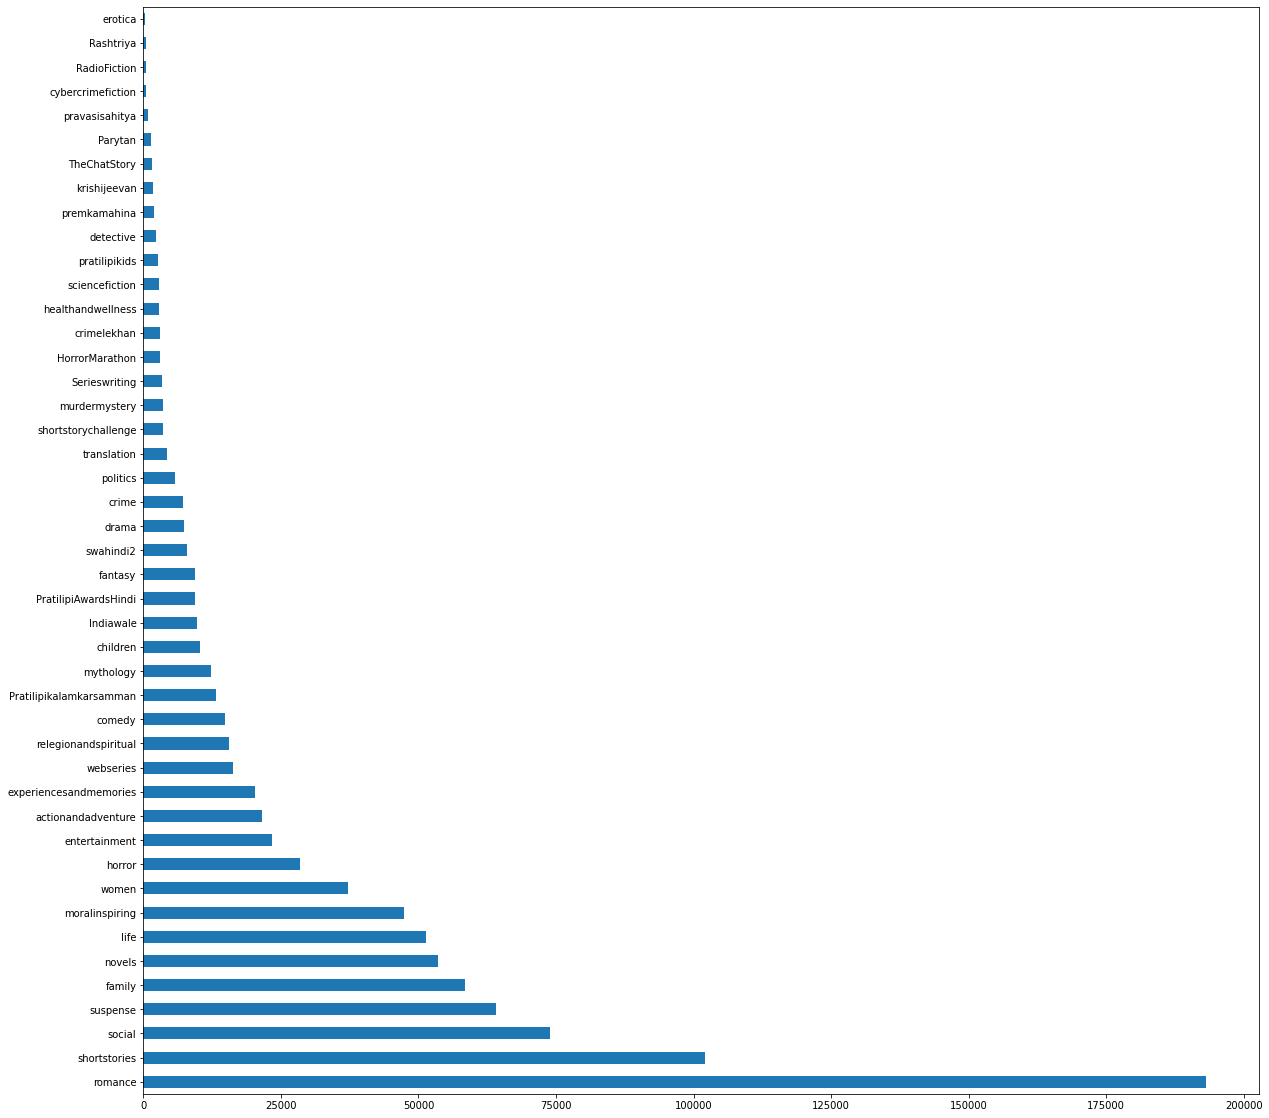

In [13]:
print(metadata["category_name"].value_counts().plot(kind='barh'))

## Check if one pratilipi can have multiple topics or not ?!

In [14]:
# Considering only one author is writing one story.
dupdata = metadata[metadata.duplicated(['pratilipi_id'])]
print("Duplicate Rows based on a pratilipi ids:", len(dupdata))

Duplicate Rows based on a pratilipi ids: 467808


So we know that if we group by pratilipi_id one story can have multiple category to them.

## Check if one pratilipi can have multiple authors or not ?!

In [15]:
# Considering only one author is writing one story.
dupdata = metadata[metadata.duplicated(['pratilipi_id',"author_id"])]
print("Duplicate Rows based on a pratilipi ids:", len(dupdata))

Duplicate Rows based on a pratilipi ids: 467808


So we know that if we group by pratilipi_id,author_id still number of duplication is same suggesting that one story cannot have multiple author to them.


## Check distribution of reading time across data

In [16]:
metadata.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


In [17]:
lis = [8*x for x in range(200)]

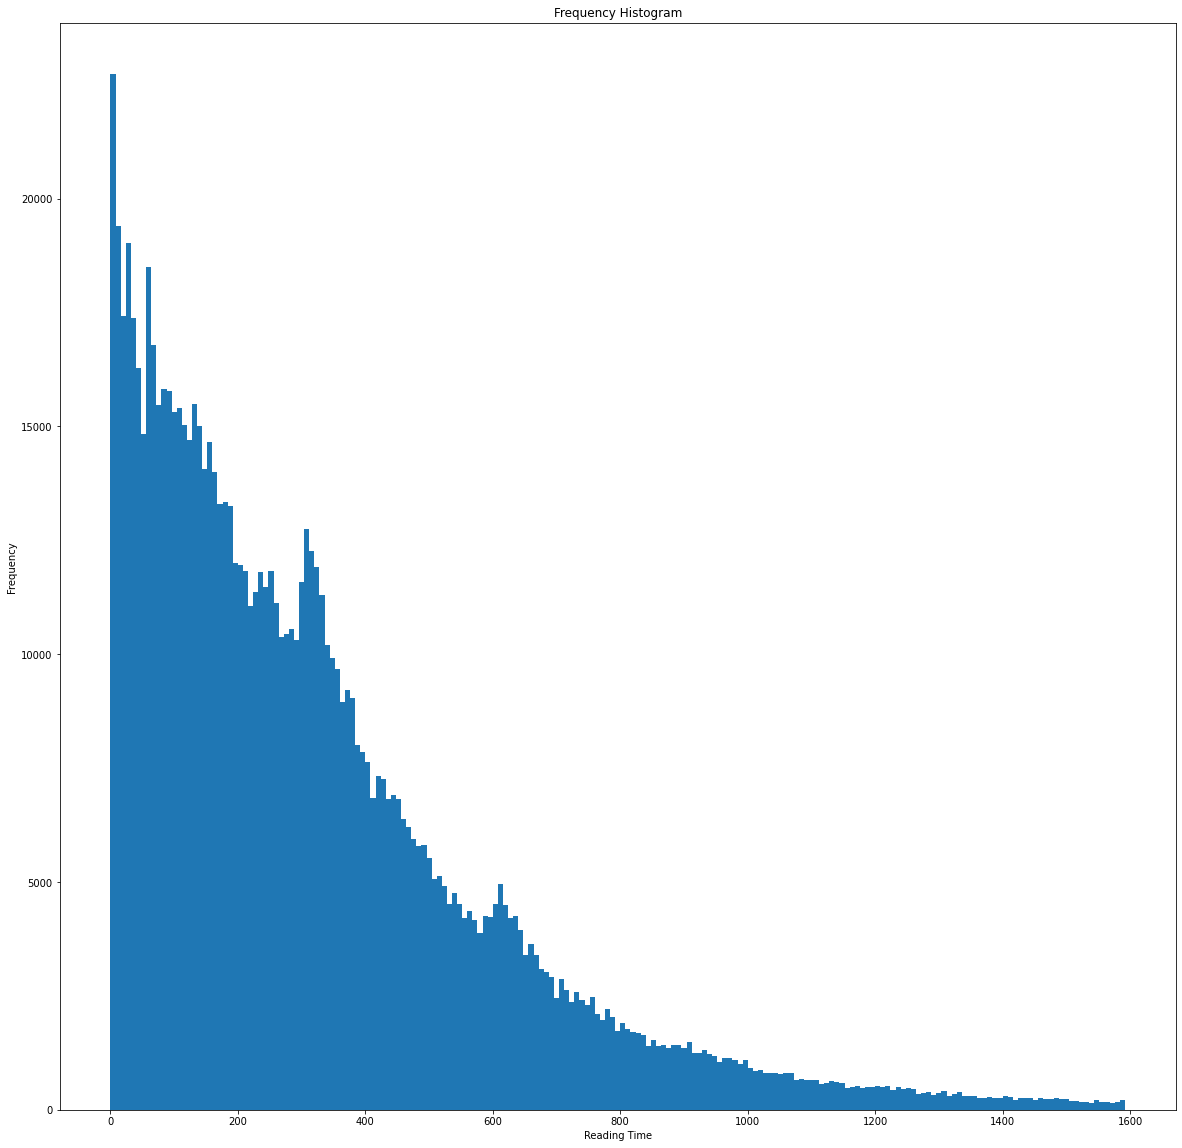

In [18]:
# distribution of reading time
x =metadata["reading_time"]
plt.hist(x, bins=lis)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency',xlabel="Reading Time");

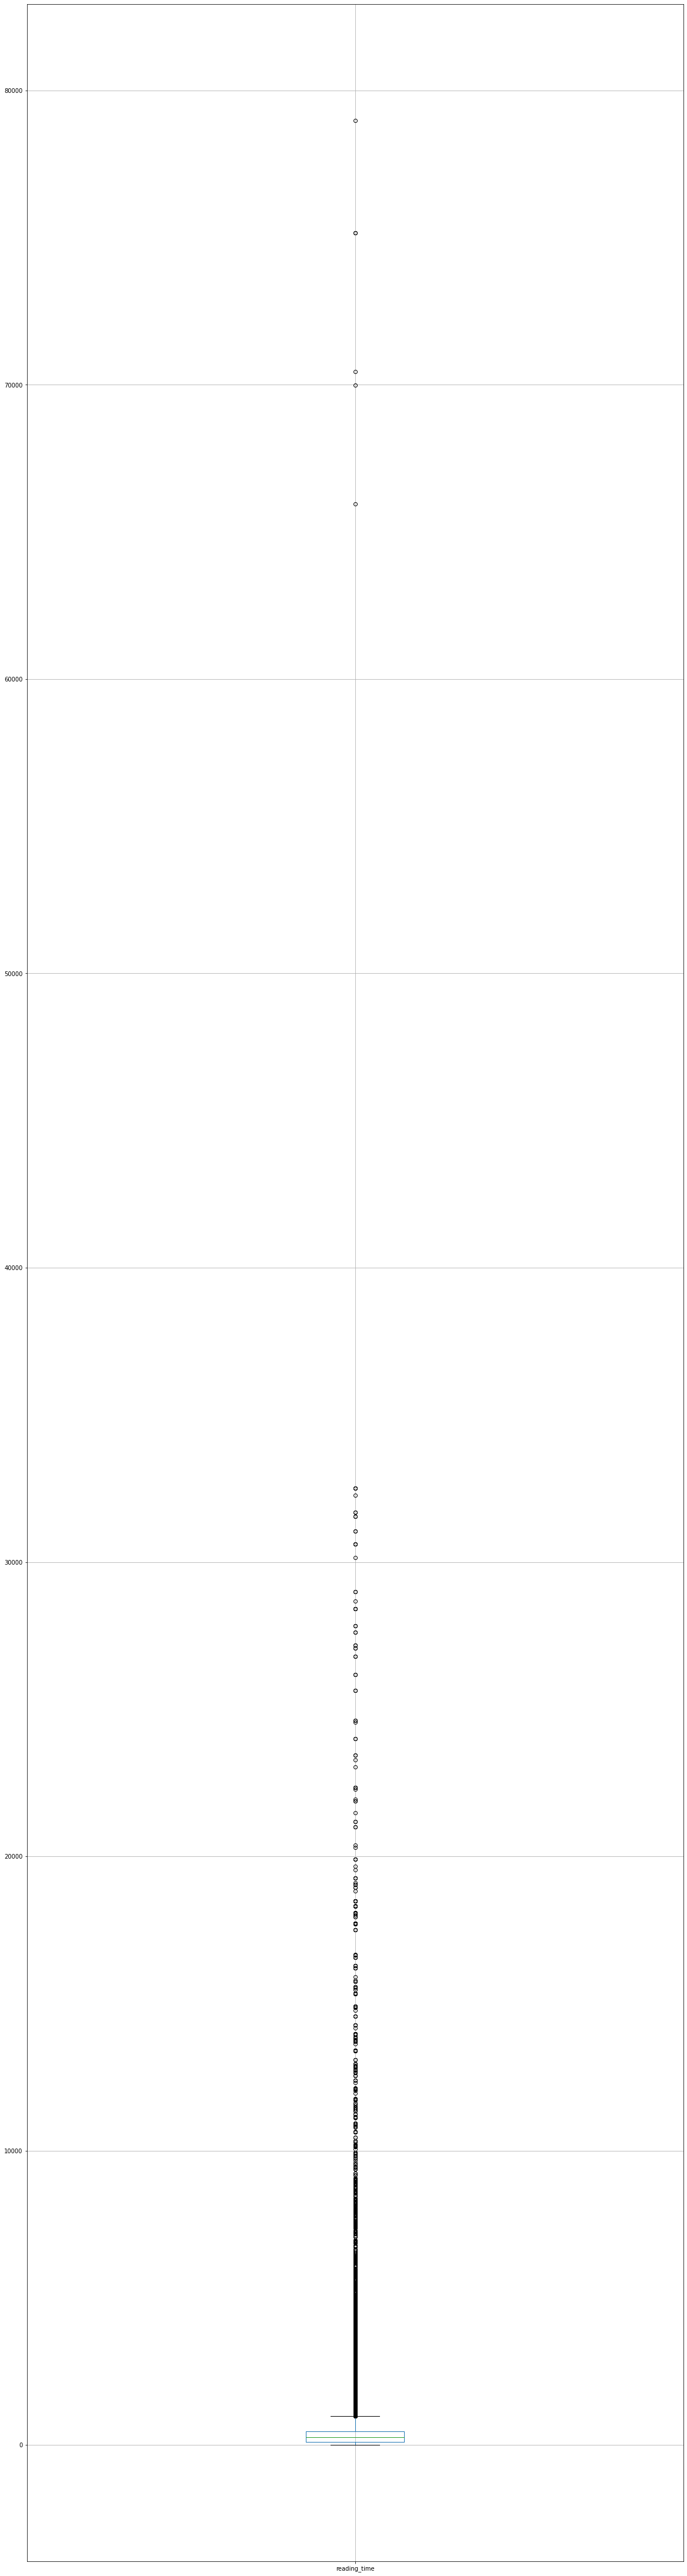

In [19]:
# undertading IQR range and outliers
metadata.boxplot(column=['reading_time'], return_type='axes',figsize=(20,80));

In [20]:
def inter_quantile_range(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
     
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    if lower_range<0:
        lower_range = 0
    print("IQR range for column is: %s-%s" % (lower_range, upper_range))

In [21]:
inter_quantile_range(metadata, col="reading_time")

IQR value for column reading_time is: 350.0
IQR range for column is: 0-986.0


In [22]:
metadata["reading_time"].min(),metadata["reading_time"].max()

(0, 78983)

In [23]:
len(metadata[metadata["reading_time"]>986])

44710

In [24]:
len(metadata[metadata["reading_time"]<=0])

4055

* We can find that there are quite a few (about 44710) outliers in the dataset according to +- 1.5 * IQR range. Apart from this we find about about 4055 instance of 0 reading time

## Check distribution of reading percent across data

In [25]:
indata.head()

,user_id,pratilipi_id,read_percent,updated_at
0,5506791961876448,1377786228262109,100.0,2022-03-22 10:29:57.291
1,5506791971543560,1377786223038206,40.0,2022-03-19 13:49:25.660
2,5506791996468218,1377786227025240,100.0,2022-03-21 17:28:47.288
3,5506791978752866,1377786222398208,65.0,2022-03-21 07:39:25.183
4,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777


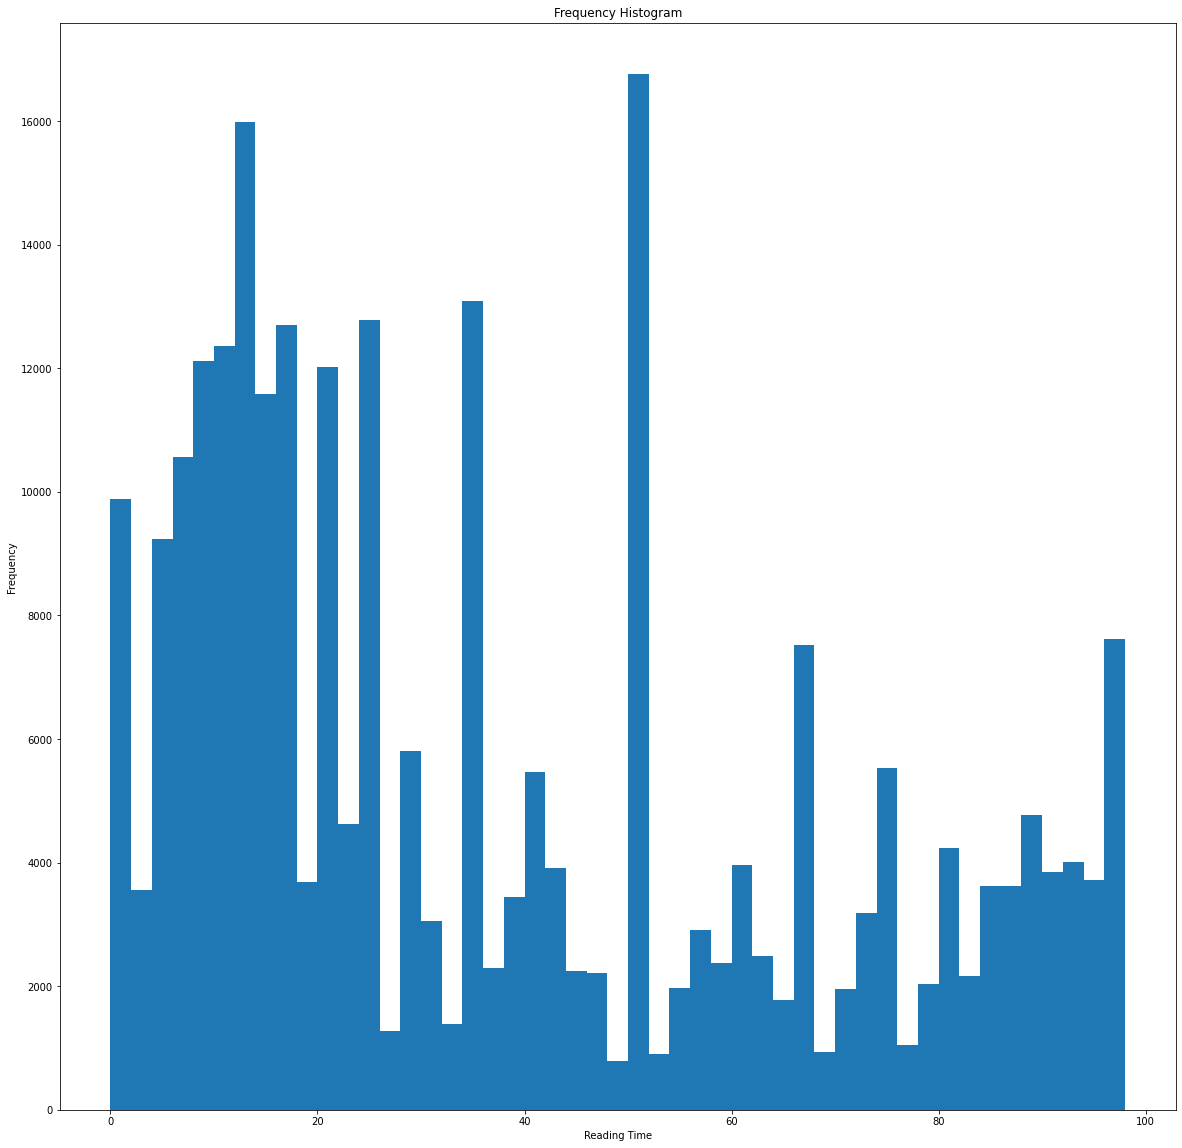

In [26]:
x =indata["read_percent"]
plt.hist(x, bins= [2*x for x in range(50)])
plt.gca().set(title='Frequency Histogram', ylabel='Frequency',xlabel="Reading Time");

In [27]:
len(indata[indata["read_percent"]>100])

24

##### So we have outliers in interaction dataset read percent with few greater than 100 which is most possibly annomaly!

In [28]:
len(indata[indata["read_percent"]==0])

9570

##### Many instances of read percent zero maybe due to technical glitch or closing session before starting the pratilipi

## Distribution of date across updated at in interaction data and published at in metadata

In [29]:
indata.columns

Index(['user_id', 'pratilipi_id', 'read_percent', 'updated_at'], dtype='object')

In [30]:
indata['updated_at'].max(),indata['updated_at'].min()

('2022-03-23 00:08:25.306', '2022-03-18 15:14:41.827')

In [31]:
indata['updated_at'].dtype

dtype('O')

In [32]:
indata['updated_at'] = indata['updated_at'].astype("datetime64")

In [33]:
indata['updated_at'].dtype

dtype('<M8[ns]')

<AxesSubplot:xlabel='updated_at'>

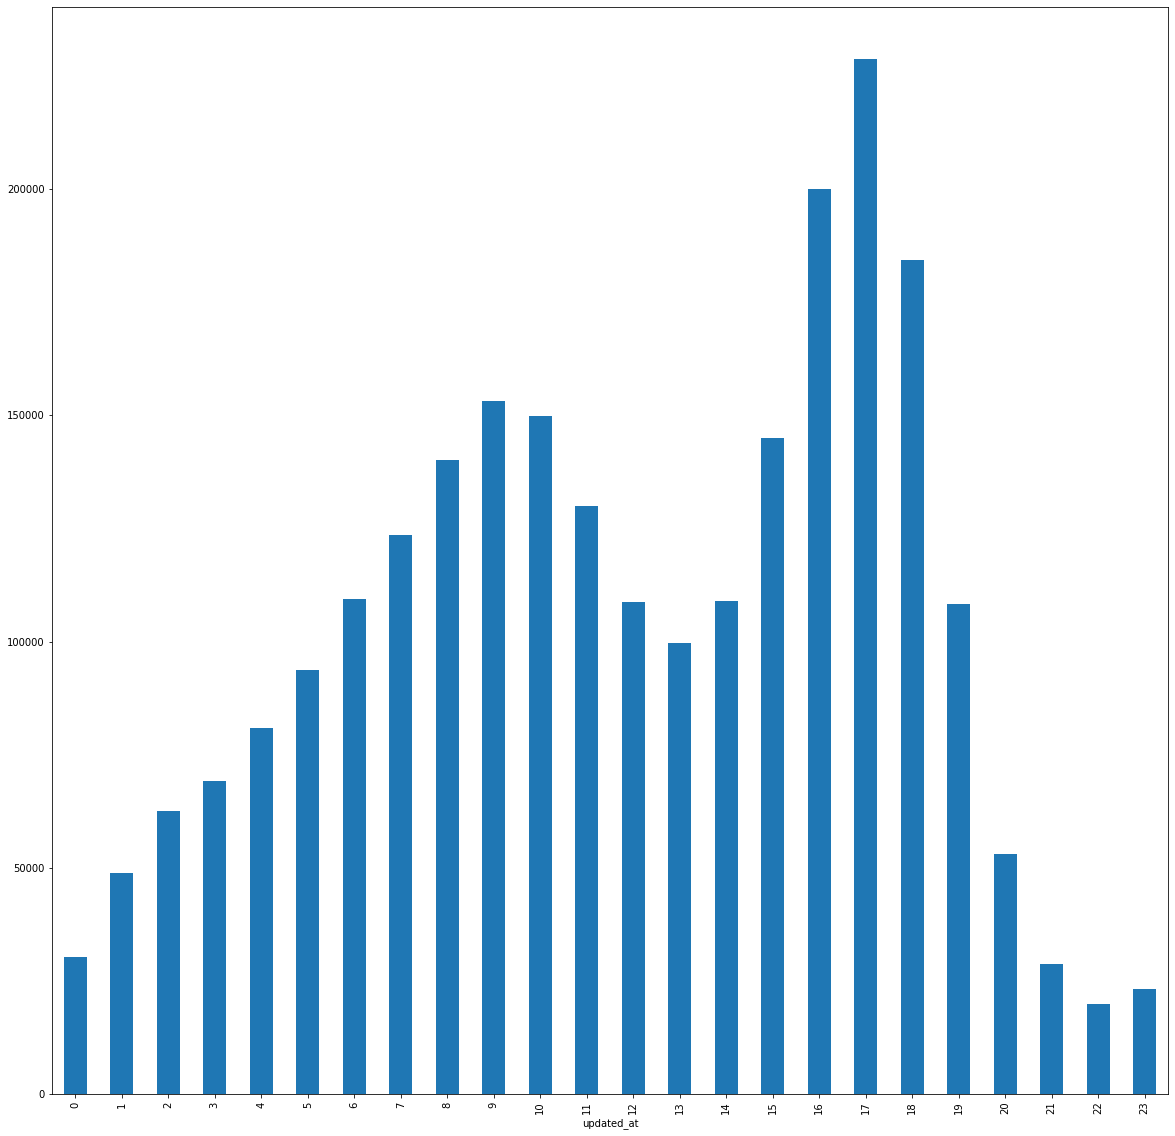

In [34]:
indata["updated_at"].groupby(indata["updated_at"].dt.hour).count().plot(kind="bar")

The peak time for the pratilipi users is around 3pm to 7pm everyday.

In [35]:
metadata.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


In [36]:
metadata["published_at"] = metadata["published_at"].astype("datetime64")

<AxesSubplot:xlabel='published_at'>

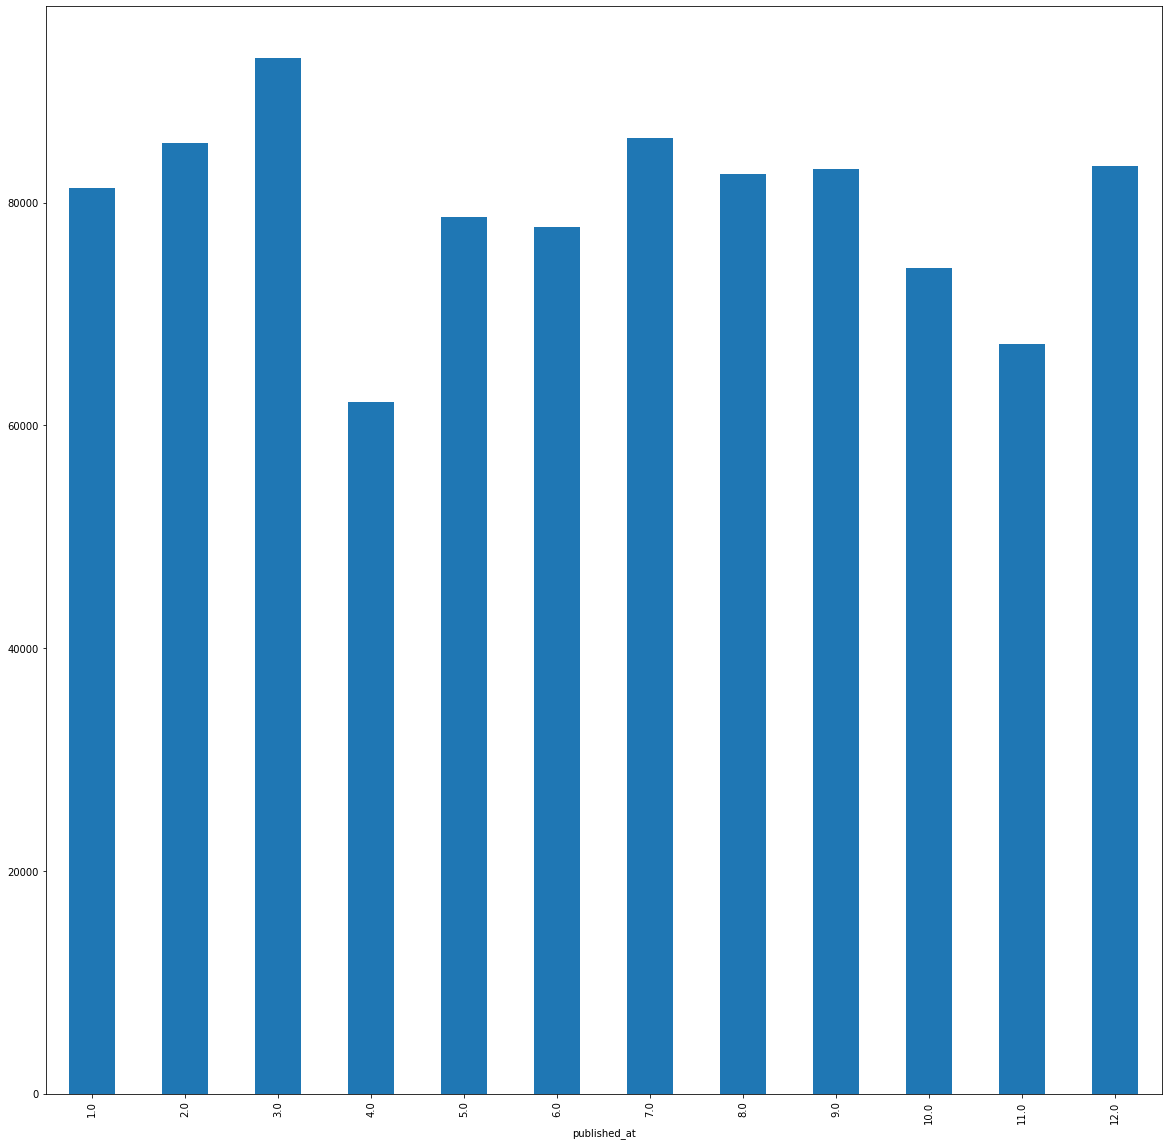

In [37]:
metadata["published_at"].groupby(metadata["published_at"].dt.month).count().plot(kind="bar")

### Publishing all around the year suggesting continous author engagement.

<AxesSubplot:xlabel='published_at'>

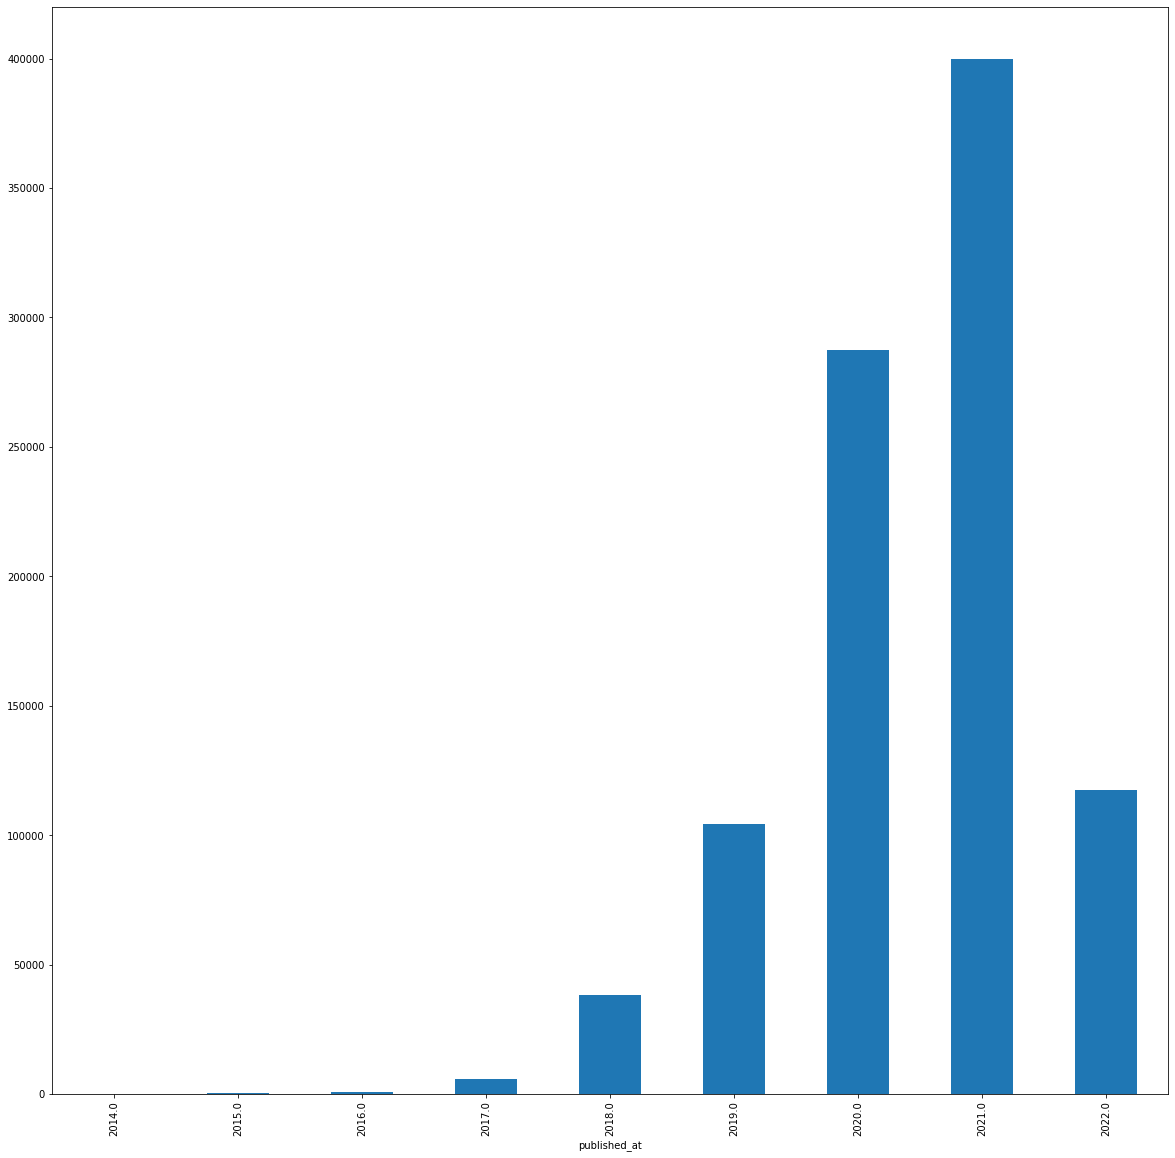

In [38]:
metadata["published_at"].groupby(metadata["published_at"].dt.year).count().plot(kind="bar")

##### Engagment is increasing over the years

<AxesSubplot:xlabel='published_at'>

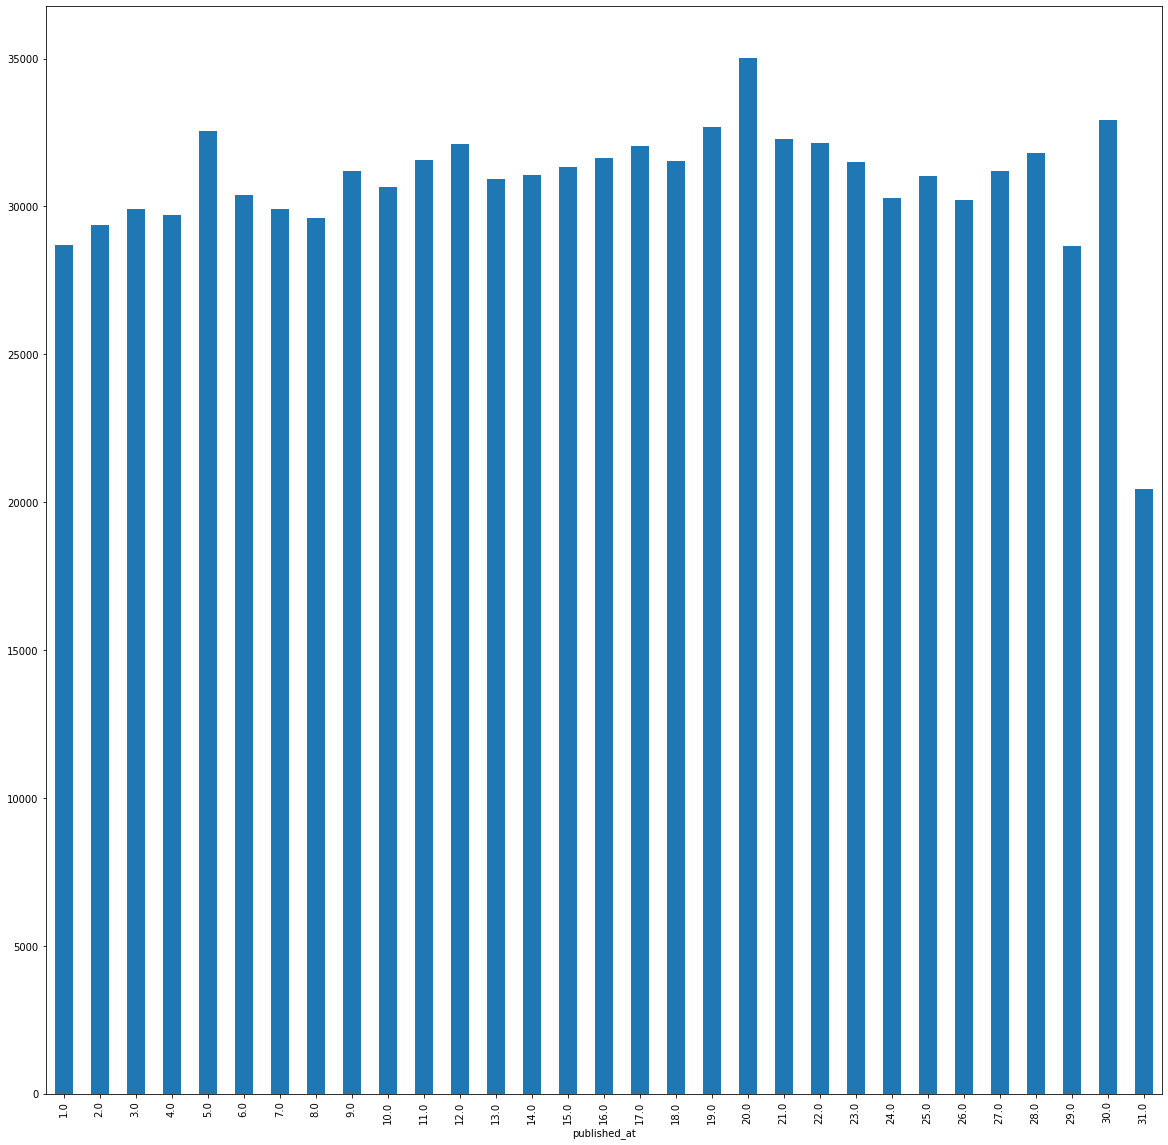

In [39]:
metadata["published_at"].groupby(metadata["published_at"].dt.day).count().plot(kind="bar")

## EDA summary

In [40]:
indata.head()

,user_id,pratilipi_id,read_percent,updated_at
0,5506791961876448,1377786228262109,100.0,2022-03-22 10:29:57.291
1,5506791971543560,1377786223038206,40.0,2022-03-19 13:49:25.660
2,5506791996468218,1377786227025240,100.0,2022-03-21 17:28:47.288
3,5506791978752866,1377786222398208,65.0,2022-03-21 07:39:25.183
4,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777


In [41]:
metadata.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


So far we have discovered few point to deep dive in the dataset and clean the dataset
* In metadata we have several instance of 0 second reading time which is quite wierd and caused maybe be due to some glich in collecting dataset or in somecases empty stories possibly(guess).
* Also in metadata we can also find instances of pratilipi with more than 10000 second(more than 2.5 hours ) reading time suggesting very large stories
* One partilipi can have multiple category but always a single author.
* In interaction data we found few instances of greater than 100 read_percent which is quite possibly some technical glitch cause it has only 14 such instances. ( if there were much more such instances have been possiblity of re-reading multiple time. )
* In interaction data we also found multiple 0 percent reading time which might be either user stopping the session before it start or some app related bug.
* Engagement around the month is similar and continously increasing across the year

## Cleaning Dataset and Treating Outliers and Feature engineering

* I won't be removing outlier anywhere except for reading percent in the assigment due to lack of knowledge of the actual reason

* Since there can be multiple topics for single pratilipi I will group them up in single list rather than using them individually

In [42]:
# converting innstance > 100 read_percent to =100 percent

In [43]:
## Any entry having greater than 100 percent read is converted back to 100 percent
indata['read_percent'] = indata['read_percent'].apply(lambda x: x if x<=100 else 100)

In [44]:
len(indata[indata["read_percent"]>100])
# no value with mor e than 100 percent

0

#### We will also remove interaction of those users having less than 20 interaction. 
* Intution is as per assigment we want about 5 prediction per user with 75-25 train test split so data is kept at 20. Also this problem is known as **cold start problem** in recommendation system in which it is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.

* For this reason, we are keeping in the dataset only users with at least 20 interactions.

In [45]:
countdf = indata.groupby('user_id').count()

In [46]:
countdf.head()

,pratilipi_id,read_percent,updated_at
user_id,,,
3257552805995172,6,6,6
3257621147984548,2,2,2
3260243929637540,1,1,1
3260275089121956,37,37,37
3260433621754532,2,2,2


In [47]:
indata = indata.loc[indata['user_id'].isin(countdf[countdf['pratilipi_id'] > 20].index)].reset_index(drop = True)

In [48]:
# many user_id with less than 20 interaction dropped out
indata.shape

(1565577, 4)

In [49]:
metadata.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


In [50]:
metadata.columns

Index(['author_id', 'pratilipi_id', 'category_name', 'reading_time',
       'updated_at', 'published_at'],
      dtype='object')

In [51]:
# Number of duplicates left after droping in pratilipi are 486693
len(metadata.drop_duplicates(subset = ["pratilipi_id"]))

486693

In [52]:
g = {'category_name':lambda x: list(x), 
     'updated_at':'max',
     'published_at' : 'min',
     "reading_time" : "mean"
    }

meta = metadata.groupby(['author_id', 'pratilipi_id']).agg(g).reset_index()

In [53]:
meta.head()

,author_id,pratilipi_id,category_name,updated_at,published_at,reading_time
0,-9070332352853360,312572401325768,"[novels, politics, social]",2018-12-03 01:57:32,2017-12-04 18:08:16,0.0
1,-9070332352853358,-96530313603384,[horror],2018-08-17 10:28:18,2017-12-04 19:11:01,0.0
2,-4566636240762225,1377786218853788,"[novels, romance, suspense]",2022-01-17 18:04:49,2020-04-27 09:31:23,81.0
3,-4566636240762225,1377786218889274,"[novels, romance, suspense]",2020-05-05 18:02:26,2020-05-05 18:02:26,112.0
4,-4566636240762225,1377786224904125,"[detective, romance, murdermystery]",2021-07-28 15:23:45,2021-07-28 14:14:45,262.0


In [54]:
meta.shape

(486693, 6)

In [55]:
# Changed ids to positive ( As i don't find any positive conterpart so it won't lead to duplicate issue)
meta["pratilipi_id"] = meta.apply(lambda x : abs(x["pratilipi_id"]),axis = 1)

In [56]:
meta["author_id"] = meta.apply(lambda x : abs(x["author_id"]),axis = 1)

In [57]:
# Converting ids have no effect on dataset
len(meta.drop_duplicates(subset=["author_id","pratilipi_id"]))

486693

In [58]:
meta.head()

,author_id,pratilipi_id,category_name,updated_at,published_at,reading_time
0,9070332352853360,312572401325768,"[novels, politics, social]",2018-12-03 01:57:32,2017-12-04 18:08:16,0.0
1,9070332352853358,96530313603384,[horror],2018-08-17 10:28:18,2017-12-04 19:11:01,0.0
2,4566636240762225,1377786218853788,"[novels, romance, suspense]",2022-01-17 18:04:49,2020-04-27 09:31:23,81.0
3,4566636240762225,1377786218889274,"[novels, romance, suspense]",2020-05-05 18:02:26,2020-05-05 18:02:26,112.0
4,4566636240762225,1377786224904125,"[detective, romance, murdermystery]",2021-07-28 15:23:45,2021-07-28 14:14:45,262.0


In [59]:
meta["month"] = meta["published_at"].dt.month

In [60]:
meta["year"] = meta["published_at"].dt.year

In [61]:
meta.head()

,author_id,pratilipi_id,category_name,updated_at,published_at,reading_time,month,year
0,9070332352853360,312572401325768,"[novels, politics, social]",2018-12-03 01:57:32,2017-12-04 18:08:16,0.0,12.0,2017.0
1,9070332352853358,96530313603384,[horror],2018-08-17 10:28:18,2017-12-04 19:11:01,0.0,12.0,2017.0
2,4566636240762225,1377786218853788,"[novels, romance, suspense]",2022-01-17 18:04:49,2020-04-27 09:31:23,81.0,4.0,2020.0
3,4566636240762225,1377786218889274,"[novels, romance, suspense]",2020-05-05 18:02:26,2020-05-05 18:02:26,112.0,5.0,2020.0
4,4566636240762225,1377786224904125,"[detective, romance, murdermystery]",2021-07-28 15:23:45,2021-07-28 14:14:45,262.0,7.0,2021.0


In [62]:
#helps decrease the speard and make data bit more uniform
meta['reading_time_min'] = meta['reading_time'].apply(lambda x: int(x/60))

In [63]:
meta.head()

,author_id,pratilipi_id,category_name,updated_at,published_at,reading_time,month,year,reading_time_min
0,9070332352853360,312572401325768,"[novels, politics, social]",2018-12-03 01:57:32,2017-12-04 18:08:16,0.0,12.0,2017.0,0
1,9070332352853358,96530313603384,[horror],2018-08-17 10:28:18,2017-12-04 19:11:01,0.0,12.0,2017.0,0
2,4566636240762225,1377786218853788,"[novels, romance, suspense]",2022-01-17 18:04:49,2020-04-27 09:31:23,81.0,4.0,2020.0,1
3,4566636240762225,1377786218889274,"[novels, romance, suspense]",2020-05-05 18:02:26,2020-05-05 18:02:26,112.0,5.0,2020.0,1
4,4566636240762225,1377786224904125,"[detective, romance, murdermystery]",2021-07-28 15:23:45,2021-07-28 14:14:45,262.0,7.0,2021.0,4


In [64]:
indata.head()

,user_id,pratilipi_id,read_percent,updated_at
0,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777
1,5506791963323596,1377786228041122,7.0,2022-03-18 16:48:11.675
2,5506791954583270,1377786219622753,100.0,2022-03-18 18:05:29.744
3,5506791953653126,1377786226770101,20.0,2022-03-19 19:04:04.430
4,5343102224474788,1377786218197485,22.0,2022-03-21 18:24:32.699


In [65]:
# Remove all stories published after the minimum intereaction datetime so that recommendation is evaluated fairly
indata["updated_at"].min()

Timestamp('2022-03-18 15:14:41.827000')

In [66]:
meta.shape

(486693, 9)

In [67]:
meta = meta[meta["published_at"]<indata["updated_at"].min()].reset_index(drop = True)

In [68]:
meta.shape

(482321, 9)

In [69]:
indata.shape

(1565577, 4)

In [70]:
indata = indata[indata["pratilipi_id"].isin(meta["pratilipi_id"].unique())].reset_index(drop = True)

In [71]:
# Remove interactions with record of their metadata 
indata.shape

(869458, 4)

In [72]:
meta.head()

,author_id,pratilipi_id,category_name,updated_at,published_at,reading_time,month,year,reading_time_min
0,9070332352853360,312572401325768,"[novels, politics, social]",2018-12-03 01:57:32,2017-12-04 18:08:16,0.0,12.0,2017.0,0
1,9070332352853358,96530313603384,[horror],2018-08-17 10:28:18,2017-12-04 19:11:01,0.0,12.0,2017.0,0
2,4566636240762225,1377786218853788,"[novels, romance, suspense]",2022-01-17 18:04:49,2020-04-27 09:31:23,81.0,4.0,2020.0,1
3,4566636240762225,1377786218889274,"[novels, romance, suspense]",2020-05-05 18:02:26,2020-05-05 18:02:26,112.0,5.0,2020.0,1
4,4566636240762225,1377786224904125,"[detective, romance, murdermystery]",2021-07-28 15:23:45,2021-07-28 14:14:45,262.0,7.0,2021.0,4


In [73]:
# we will remove updated_at and published_at(features already captured)
meta.drop(["updated_at","published_at","author_id","reading_time"],axis = 1,inplace = True)

In [74]:
meta.head()

,pratilipi_id,category_name,month,year,reading_time_min
0,312572401325768,"[novels, politics, social]",12.0,2017.0,0
1,96530313603384,[horror],12.0,2017.0,0
2,1377786218853788,"[novels, romance, suspense]",4.0,2020.0,1
3,1377786218889274,"[novels, romance, suspense]",5.0,2020.0,1
4,1377786224904125,"[detective, romance, murdermystery]",7.0,2021.0,4


In [75]:
meta.columns

Index(['pratilipi_id', 'category_name', 'month', 'year', 'reading_time_min'], dtype='object')

In [76]:
indata.head()

,user_id,pratilipi_id,read_percent,updated_at
0,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777
1,5506791963323596,1377786228041122,7.0,2022-03-18 16:48:11.675
2,5506791954583270,1377786219622753,100.0,2022-03-18 18:05:29.744
3,5506791953653126,1377786226770101,20.0,2022-03-19 19:04:04.430
4,5343102224474788,1377786218197485,22.0,2022-03-21 18:24:32.699


In [77]:
df = indata.merge(meta, on = 'pratilipi_id',how = 'left')
df.head()

,user_id,pratilipi_id,read_percent,updated_at,category_name,month,year,reading_time_min
0,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777,"[romance, suspense, swahindi2]",3.0,2022.0,13
1,5506791963323596,1377786228041122,7.0,2022-03-18 16:48:11.675,"[actionandadventure, romance, swahindi2]",3.0,2022.0,10
2,5506791954583270,1377786219622753,100.0,2022-03-18 18:05:29.744,"[novels, romance, entertainment]",6.0,2020.0,19
3,5506791953653126,1377786226770101,20.0,2022-03-19 19:04:04.430,"[romance, entertainment]",12.0,2021.0,4
4,5343102224474788,1377786218197485,22.0,2022-03-21 18:24:32.699,"[suspense, women, horror]",3.0,2020.0,24


In [78]:
#function to build entire feature set and merging both dataset
def create_feature_set(meta,indata):
    """ 
    Process df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    df = indata.merge(meta, on = 'pratilipi_id',how = 'left')
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['category_name'].apply(lambda x: ",".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)
    #concanenate all features
    final = pd.concat([df,genre_df], axis = 1)
    final.drop(["category_name"],axis =1,inplace = True)
    print(genre_df.columns)
    return final

In [79]:
final = create_feature_set(meta,indata)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Index(['genre|actionandadventure', 'genre|children', 'genre|comedy',
       'genre|crime', 'genre|crimelekhan', 'genre|cybercrimefiction',
       'genre|detective', 'genre|drama', 'genre|entertainment',
       'genre|erotica', 'genre|experiencesandmemories', 'genre|family',
       'genre|fantasy', 'genre|healthandwellness', 'genre|horror',
       'genre|horrormarathon', 'genre|indiawale', 'genre|krishijeevan',
       'genre|life', 'genre|moralinspiring', 'genre|murdermystery',
       'genre|mythology', 'genre|novels', 'genre|parytan', 'genre|politics',
       'genre|pratilipiawardshindi', 'genre|pratilipikalamkarsamman',
       'genre|pratilipikids', 'genre|pravasisahitya', 'genre|premkamahina',
       'genre|radiofiction', 'genre|rashtriya', 'genre|relegionandspiritual',
       'genre|romance', 'genre|sciencefiction', 'genre|serieswriting',
       'genre|shortstories', 'genre|shortstorychallenge', 'genre|social',
       'genre|suspense', 'genre|swahindi2', 'genre|thechatstory',
      

In [80]:
final.head()

,user_id,pratilipi_id,read_percent,updated_at,month,year,reading_time_min,genre|actionandadventure,genre|children,genre|comedy,...,genre|serieswriting,genre|shortstories,genre|shortstorychallenge,genre|social,genre|suspense,genre|swahindi2,genre|thechatstory,genre|translation,genre|webseries,genre|women
0,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777,3.0,2022.0,13,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.516946,0.809373,0.0,0.0,0.0,0.000000
1,5506791963323596,1377786228041122,7.0,2022-03-18 16:48:11.675,3.0,2022.0,10,0.621989,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.740359,0.0,0.0,0.0,0.000000
2,5506791954583270,1377786219622753,100.0,2022-03-18 18:05:29.744,6.0,2020.0,19,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,5506791953653126,1377786226770101,20.0,2022-03-19 19:04:04.430,12.0,2021.0,4,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,5343102224474788,1377786218197485,22.0,2022-03-21 18:24:32.699,3.0,2020.0,24,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.366075,0.000000,0.0,0.0,0.0,0.639547


In [81]:
final.shape

(869458, 52)

### Splitting the whole dataset per user into 75-25 for train test split according to timestamp so that prediction are not done using future data

In [82]:
ranks = final.groupby('user_id')['updated_at'].rank(method='first')

In [83]:
ranks

0         41.0
1          1.0
2          1.0
3          2.0
4         17.0
          ... 
869453     2.0
869454    12.0
869455    40.0
869456     8.0
869457    25.0
Name: updated_at, Length: 869458, dtype: float64

In [84]:
counts = final['user_id'].map(df.groupby('user_id')['updated_at'].apply(len))

In [85]:
final["train"]=(ranks / counts) <= 0.75

In [86]:
final["train"].value_counts()

True     639021
False    230437
Name: train, dtype: int64

In [87]:
train,test = final[final["train"]==True].reset_index(drop = True),final[final["train"]==False].reset_index(drop = True)

In [88]:
len(train["user_id"].unique()),len(test["user_id"].unique())

(34603, 34779)

In [89]:
train.shape,test.shape

((639021, 53), (230437, 53))

In [90]:
test.head()

,user_id,pratilipi_id,read_percent,updated_at,month,year,reading_time_min,genre|actionandadventure,genre|children,genre|comedy,...,genre|shortstories,genre|shortstorychallenge,genre|social,genre|suspense,genre|swahindi2,genre|thechatstory,genre|translation,genre|webseries,genre|women,train
0,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777,3.0,2022.0,13,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.516946,0.809373,0.0,0.0,0.0,0.0,False
1,5506791954664507,1377786226276690,100.0,2022-03-21 06:57:26.966,11.0,2021.0,15,0.000000,0.0,0.0,...,0.743846,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,False
2,5506791956948482,1377786218123342,100.0,2022-03-21 06:47:13.749,2.0,2020.0,13,0.532209,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,False
3,5506791962136691,1377786217848278,100.0,2022-03-21 14:40:23.967,1.0,2020.0,3,0.334313,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,False
4,5506791959254722,1377786221721571,100.0,2022-03-22 05:08:42.618,11.0,2020.0,10,0.756797,0.0,0.0,...,0.000000,0.0,0.0,0.575353,0.000000,0.0,0.0,0.0,0.0,False


In [91]:
test = test[test["user_id"].isin(train["user_id"].unique())]
test = test[test["pratilipi_id"].isin(train["pratilipi_id"].unique())]

In [92]:
test.shape

(217605, 53)

In [93]:
train.to_csv("train.csv",index = False)
test.to_csv("test.csv",index = False)

## LightFM

In [94]:
from copy import deepcopy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score,recall_at_k,reciprocal_rank
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

### Loading Dataset¶


In [95]:
complete_train = pd.read_csv("/kaggle/input/pratilipi-data-ml/train.csv")
complete_test = pd.read_csv("/kaggle/input/pratilipi-data-ml/test.csv")

In [96]:
complete_train.head()


,user_id,pratilipi_id,read_percent,updated_at,month,year,reading_time_min,genre|actionandadventure,genre|children,genre|comedy,...,genre|shortstories,genre|shortstorychallenge,genre|social,genre|suspense,genre|swahindi2,genre|thechatstory,genre|translation,genre|webseries,genre|women,train
0,5506791963323596,1377786228041122,7.0,2022-03-18 16:48:11.675,3.0,2022.0,10,0.621989,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.740359,0.0,0.0,0.0,0.000000,True
1,5506791954583270,1377786219622753,100.0,2022-03-18 18:05:29.744,6.0,2020.0,19,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,True
2,5506791953653126,1377786226770101,20.0,2022-03-19 19:04:04.430,12.0,2021.0,4,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,True
3,5343102224474788,1377786218197485,22.0,2022-03-21 18:24:32.699,3.0,2020.0,24,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.366075,0.000000,0.0,0.0,0.0,0.639547,True
4,5506791954706721,1377786226804482,100.0,2022-03-19 08:35:47.129,12.0,2021.0,5,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,True


In [97]:
complete_test.head()


,user_id,pratilipi_id,read_percent,updated_at,month,year,reading_time_min,genre|actionandadventure,genre|children,genre|comedy,...,genre|shortstories,genre|shortstorychallenge,genre|social,genre|suspense,genre|swahindi2,genre|thechatstory,genre|translation,genre|webseries,genre|women,train
0,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777,3.0,2022.0,13,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.516946,0.809373,0.0,0.0,0.0,0.0,False
1,5506791956948482,1377786218123342,100.0,2022-03-21 06:47:13.749,2.0,2020.0,13,0.532209,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,False
2,5506791962136691,1377786217848278,100.0,2022-03-21 14:40:23.967,1.0,2020.0,3,0.334313,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,False
3,5506791959254722,1377786221721571,100.0,2022-03-22 05:08:42.618,11.0,2020.0,10,0.756797,0.0,0.0,...,0.0,0.0,0.0,0.575353,0.000000,0.0,0.0,0.0,0.0,False
4,5506791979266119,1377786227346148,100.0,2022-03-22 14:57:16.074,1.0,2022.0,8,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,False


In [98]:
complete_train.columns


Index(['user_id', 'pratilipi_id', 'read_percent', 'updated_at', 'month',
       'year', 'reading_time_min', 'genre|actionandadventure',
       'genre|children', 'genre|comedy', 'genre|crime', 'genre|crimelekhan',
       'genre|cybercrimefiction', 'genre|detective', 'genre|drama',
       'genre|entertainment', 'genre|erotica', 'genre|experiencesandmemories',
       'genre|family', 'genre|fantasy', 'genre|healthandwellness',
       'genre|horror', 'genre|horrormarathon', 'genre|indiawale',
       'genre|krishijeevan', 'genre|life', 'genre|moralinspiring',
       'genre|murdermystery', 'genre|mythology', 'genre|novels',
       'genre|parytan', 'genre|politics', 'genre|pratilipiawardshindi',
       'genre|pratilipikalamkarsamman', 'genre|pratilipikids',
       'genre|pravasisahitya', 'genre|premkamahina', 'genre|radiofiction',
       'genre|rashtriya', 'genre|relegionandspiritual', 'genre|romance',
       'genre|sciencefiction', 'genre|serieswriting', 'genre|shortstories',
       'genre|sh

* "Current" set will represent the interactions known at the time of training the complete model. "New" set will represent the new interactions.

* So test data is "New" data and train data is "Current" data

In [99]:
# Interaction data from complete data 
interactions_current = complete_train[['user_id', 'pratilipi_id', 'read_percent',"updated_at"]]
interactions_new = complete_test[['user_id', 'pratilipi_id', 'read_percent',"updated_at"]]
interactions = pd.concat([interactions_current,interactions_new])

In [100]:
interactions_new.shape,interactions_current.shape


((217605, 4), (639021, 4))

In [101]:
# Since new users were removed at the time of creating data we don't have new user is test dataset
new_users = np.setdiff1d(interactions_new["user_id"], interactions_current["user_id"])
old_users = np.intersect1d(interactions_new["user_id"], interactions_current["user_id"])

print("Number of new users in new set: {}".format(len(new_users)))
print("Number of current users in new set: {}".format(len(old_users)))

Number of new users in new set: 0
Number of current users in new set: 34378


In [102]:
# Since new items(pratilipi) were removed at the time of creating data we don't have new user is test dataset

new_items = np.setdiff1d(interactions_new['pratilipi_id'], interactions_current['pratilipi_id'])
old_items = np.intersect1d(interactions_new['pratilipi_id'], interactions_current['pratilipi_id'])

print("Number of new items in new set: {}".format(len(new_items)))
print("Number of current items in new set: {}".format(len(old_items)))

Number of new items in new set: 0
Number of current items in new set: 54248


## User, item features

In lightfm we have the flexibility of giving metadata directly to the recommender system. In our case the only metadata available is of that of item. Since no user feature was received we will not input any user feature for recommendation and solely depend on item feature.

In [103]:
complete_train.drop(["train"],inplace = True,axis = 1)
complete_test.drop(["train"],inplace = True,axis = 1)

In [104]:
complete_train.columns


Index(['user_id', 'pratilipi_id', 'read_percent', 'updated_at', 'month',
       'year', 'reading_time_min', 'genre|actionandadventure',
       'genre|children', 'genre|comedy', 'genre|crime', 'genre|crimelekhan',
       'genre|cybercrimefiction', 'genre|detective', 'genre|drama',
       'genre|entertainment', 'genre|erotica', 'genre|experiencesandmemories',
       'genre|family', 'genre|fantasy', 'genre|healthandwellness',
       'genre|horror', 'genre|horrormarathon', 'genre|indiawale',
       'genre|krishijeevan', 'genre|life', 'genre|moralinspiring',
       'genre|murdermystery', 'genre|mythology', 'genre|novels',
       'genre|parytan', 'genre|politics', 'genre|pratilipiawardshindi',
       'genre|pratilipikalamkarsamman', 'genre|pratilipikids',
       'genre|pravasisahitya', 'genre|premkamahina', 'genre|radiofiction',
       'genre|rashtriya', 'genre|relegionandspiritual', 'genre|romance',
       'genre|sciencefiction', 'genre|serieswriting', 'genre|shortstories',
       'genre|sh

In [105]:
# List of item features we have for a single pratilipi
item_cols = ['pratilipi_id','month',
       'year', 'reading_time_min', 'genre|actionandadventure',
       'genre|children', 'genre|comedy', 'genre|crime', 'genre|crimelekhan',
       'genre|cybercrimefiction', 'genre|detective', 'genre|drama',
       'genre|entertainment', 'genre|erotica', 'genre|experiencesandmemories',
       'genre|family', 'genre|fantasy', 'genre|healthandwellness',
       'genre|horror', 'genre|horrormarathon', 'genre|indiawale',
       'genre|krishijeevan', 'genre|life', 'genre|moralinspiring',
       'genre|murdermystery', 'genre|mythology', 'genre|novels',
       'genre|parytan', 'genre|politics', 'genre|pratilipiawardshindi',
       'genre|pratilipikalamkarsamman', 'genre|pratilipikids',
       'genre|pravasisahitya', 'genre|premkamahina', 'genre|radiofiction',
       'genre|rashtriya', 'genre|relegionandspiritual', 'genre|romance',
       'genre|sciencefiction', 'genre|serieswriting', 'genre|shortstories',
       'genre|shortstorychallenge', 'genre|social', 'genre|suspense',
       'genre|swahindi2', 'genre|thechatstory', 'genre|translation',
       'genre|webseries', 'genre|women']

In [106]:
item_features_current = complete_train[item_cols].drop_duplicates(subset = ['pratilipi_id']).reset_index(drop = True)
item_features_new = complete_test[item_cols].drop_duplicates(subset = ['pratilipi_id']).reset_index(drop = True)

In [107]:
item_features_current = item_features_current[item_features_current["pratilipi_id"].isin(interactions_current["pratilipi_id"])]
item_features_new = item_features_new[item_features_new["pratilipi_id"].isin(interactions_new["pratilipi_id"])]

print("Number of current items: {}".format(len(item_features_current)))
print("Number of new items: {}".format(len(item_features_new)))

Number of current items: 96158
Number of new items: 54248


In [108]:
item_features = pd.concat([item_features_current])


## Transform to LightFM format¶

Dataset
To train the LightFM model the dataset must be converted in a specific format.

In [109]:
print("Max user id: {}".format(interactions_current['user_id'].max()))
print("Max pratilipi id: {}".format(interactions_current['pratilipi_id'].max()))

Max user id: 5506791996674814
Max pratilipi id: 1377786228304062


In [110]:
from lightfm.data import Dataset


In [111]:
user_ids_buffered = (x for x in interactions_current['user_id'].unique())
item_ids_buffered = (x for x in interactions_current['pratilipi_id'].unique())

item_feature_names = item_features.columns.tolist()
item_feature_names.remove("pratilipi_id")

# dataset = Dataset()

In [112]:
dataset = Dataset()


In [113]:
dataset.fit(
    users=user_ids_buffered,
    items=item_ids_buffered,
    item_features=item_feature_names
)

We will be using implict rating "read_percent" as the target for the lightfm model



In [114]:
def transform_interactions(interactions):
    """
    Transforms interactions data frame to the format build_interactions needs it.
    
    Returns iterable of tuples ("user_id", "pratilipi_id", 'read_percent').
    """
    return interactions[["user_id", "pratilipi_id", 'read_percent']].itertuples(index=False)

In [115]:
interaction_matrix_current, _ = dataset.build_interactions(
    transform_interactions(interactions_current))

In [116]:
interactions_current.shape


(639021, 4)

In [117]:
interaction_matrix_new, _ = dataset.build_interactions(
    transform_interactions(interactions_new))

In [118]:
interactions_new.shape


(217605, 4)

In [119]:
def transform_features(features, id_name):
    """
    Transforms features data frame to the format build_user_features / build_item_features needs it.
    
    Returns iterable of (id, [list of feature names that has value 1]).
    """
    transformed_features = []
    for row in features.to_dict(orient="records"):
        id_value = row[id_name]
        del row[id_name]
        feature_names = [key for key, value in row.items() if value == 1]
        transformed_features.append(
            (id_value, feature_names)
        )
    return transformed_features

In [120]:
item_features_matrix_current = dataset.build_item_features(
    transform_features(item_features_current, "pratilipi_id"))

In [121]:
item_features_matrix_new = dataset.build_item_features(
    transform_features(item_features_new, "pratilipi_id"))

## Train

Model definition

In [122]:
model = LightFM(loss="warp",no_components=150,
    learning_rate=0.05,random_state=2019)

### Evaluating the performance of the model

Now we have to evaluate our model to see it's performance. No matter how good your model is, if you can't evaluate your model correctly you can't imporove and trust your model. For recommendation problem, there is not very good matrics for evaluating. But luckily lightfm provides us a very rich set of evaluating matrics. In this steps, we will be calculating AUC scores for our model.

In [123]:
class Evaluator():
    """
    Helper class for model evaluation
    
    Stores the number of epochs and corresponding performance metrics in a data frame.
    Returns the number of epochs with the best validation ROC AUC.
    Prepared to handle multiple runs of the same hyperparameters, and averages up the multiple runs.
    """
    
    def __init__(self):
        self.df_evaluation = pd.DataFrame()
    def evaluate(self, epochs, model, interaction_matrix_train,item_features_matrix):
            features_current = {
               
                "item_features": item_features_matrix
            }
            evaluation_row = pd.DataFrame({
                "epochs": epochs,
                "train_precision": precision_at_k(model, interaction_matrix_train, k=10, **features_current).mean(),
                "train_auc": auc_score(model, interaction_matrix_train, **features_current).mean(),
                },
                index=[0]
            )
            self.df_evaluation = self.df_evaluation.append(evaluation_row, ignore_index=True)
    def get_best_epochs(self):
        df_evaluation_agg = self.df_evaluation.groupby("epochs").agg("mean").reset_index()
        best_epochs =  df_evaluation_agg[
            df_evaluation_agg["train_auc"] == df_evaluation_agg["train_auc"].max()
        ]["epochs"].iloc[0]
        return best_epochs


In [124]:
evaluator = Evaluator()
for epochs in [200]:
    print(f"Epochs: {epochs}")
    
    model.fit(
        interaction_matrix_current,
        epochs=epochs,
        item_features=item_features_matrix_current
    )
    
    evaluator.evaluate(
        epochs, model,
        interaction_matrix_current,item_features_matrix_current)

Epochs: 200


In [125]:
# train evealuation
evaluator.df_evaluation

,epochs,train_precision,train_auc
0,200,0.726616,0.999946


In [126]:
# test evaluation
features_new = {
               
                "item_features": item_features_matrix_new
            }

## **Evaluation metric**

* AUC : It measure the ROC AUC metric for a model: the probability that a randomly chosen positive example has a higher score than a randomly chosen negative example. A perfect score is 1.0.

* Precision at K : Measure the precision at k metric for a model: the fraction of known positives in the first k positions of the ranked list of results.A perfect score is 1.0.

* Recall at K : Measure the recall at k metric for a model: the number of positive items in the first k positions of the ranked list of results divided by the number of positive items in the test period. A perfect score is 1.0.

* Mean Reciprocal rank : Measure the reciprocal rank metric for a model: 1 / the rank of the highest ranked positive example. A perfect score is 1.0.

In [127]:
print(auc_score(model, interaction_matrix_new, **features_new).mean())


0.8544167


In [128]:
print(precision_at_k(model, interaction_matrix_new, k=10, **features_new).mean())


0.0025888649


In [129]:
print(reciprocal_rank(model, interaction_matrix_new, **features_new).mean())


0.017295029


In [130]:
print(recall_at_k(model, interaction_matrix_new, k=10, **features_new).mean())


0.0071532228935390334


## Getting recommendation for test dataset

In [131]:
def predict(model, dataset, user_item_pairs,item_features_matrix):
    user_id_mapping, user_feature_mapping, item_id_mapping, item_feature_mapping = dataset.mapping()
    predictions = model.predict(
        user_ids=np.array([user_id_mapping[x] for x in user_item_pairs["user_id"]]),
        item_ids=np.array([item_id_mapping[x] for x in user_item_pairs["pratilipi_id"]]),
        item_features=item_features_matrix
    )
    
    df_predictions = user_item_pairs.copy()
    df_predictions["prediction"] = predictions
    
    return df_predictions

def merge_interactions(df_evaluation, interactions):
    df_evaluation = df_evaluation.merge(interactions[["user_id", "pratilipi_id", "read_percent"]], on=["user_id", "pratilipi_id"], how="left")
    df_evaluation["has_interaction"] = ~df_evaluation["read_percent"].isna()
#     df_evaluation = df_evaluation.drop(columns="read_percent")
    return df_evaluation

### Jaccard Metric

The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations. We will find Jaccard metric for

Predicted vs Actual pratilipi Id
Predicted vs Actual category name

In [133]:
metadata = pd.read_csv("/kaggle/input/pratilipi-dataset/metadata.csv")


In [134]:
complete_test = complete_test.merge(metadata,on = "pratilipi_id")


In [135]:
complete_test.head()


,user_id,pratilipi_id,read_percent,updated_at_x,month,year,reading_time_min,genre|actionandadventure,genre|children,genre|comedy,...,genre|swahindi2,genre|thechatstory,genre|translation,genre|webseries,genre|women,author_id,category_name,reading_time,updated_at_y,published_at
0,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777,3.0,2022.0,13,0.0,0.0,0.0,...,0.809373,0.0,0.0,0.0,0.0,-2270332331146586,romance,811,2022-03-08 16:31:41,2022-03-08 16:31:41
1,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777,3.0,2022.0,13,0.0,0.0,0.0,...,0.809373,0.0,0.0,0.0,0.0,-2270332331146586,suspense,811,2022-03-08 16:31:41,2022-03-08 16:31:41
2,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777,3.0,2022.0,13,0.0,0.0,0.0,...,0.809373,0.0,0.0,0.0,0.0,-2270332331146586,swahindi2,811,2022-03-08 16:31:41,2022-03-08 16:31:41
3,5506791965953821,1377786228157051,100.0,2022-03-21 15:49:08.893,3.0,2022.0,13,0.0,0.0,0.0,...,0.809373,0.0,0.0,0.0,0.0,-2270332331146586,romance,811,2022-03-08 16:31:41,2022-03-08 16:31:41
4,5506791965953821,1377786228157051,100.0,2022-03-21 15:49:08.893,3.0,2022.0,13,0.0,0.0,0.0,...,0.809373,0.0,0.0,0.0,0.0,-2270332331146586,suspense,811,2022-03-08 16:31:41,2022-03-08 16:31:41


### Since predicting on 60k test data sample is unfeasible we will only predict for 1k users¶


In [136]:
g = {'pratilipi_id':lambda x: list(x)[:100] if len(list(x))>100 else list(x),
    "category_name":lambda x: list(x)}
final_test = complete_test.sort_values(['updated_at_x']).groupby(["user_id"]).agg(g).reset_index()

In [137]:
final_test["predicted_id"] = None


In [138]:
final_test.head()


,user_id,pratilipi_id,category_name,predicted_id
0,3260275089121956,"[1377786225517713, 1377786225517713, 137778622...","[romance, entertainment, entertainment, romanc...",None
1,3263998672675492,"[1377786227504834, 1377786227504834, 137778622...","[romance, novels, family, romance, novels, fam...",None
2,3264294598124196,"[1377786224259805, 1377786224259805, 137778622...","[suspense, action-and-adventure, romance, acti...",None
3,3264359729373860,"[1377786217482504, 1377786217482504, 137778621...","[suspense, novels, romance, suspense, romance,...",None
4,3267248272614052,"[1377786226443381, 1377786226443381, 137778622...","[family, moral-inspiring, romance, moral-inspi...",None


In [139]:
all_item_ids = np.unique(interactions["pratilipi_id"])

for i in range(1000):
#     try:
    user_sample_item_pairs = pd.DataFrame({
        "user_id": final_test["user_id"][i],
        "pratilipi_id": all_item_ids
    })
    predictions_sample = predict(model, dataset, user_sample_item_pairs,item_features_matrix_new )
    predictions_sample = merge_interactions(predictions_sample, interactions)
    predictions_sample = predictions_sample.sort_values("prediction", ascending=False)
    final_test["predicted_id"][i] = list(set(predictions_sample["pratilipi_id"].tolist()[:100]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [140]:
final_test=final_test[:1000]


In [141]:
### For better understanding of the recommendation we will also find category of predicted items
g = {"category_name":lambda x: list(x)}
metadict = metadata.groupby(["pratilipi_id"]).agg(g).reset_index()

In [142]:
metadata.shape


(954501, 6)

In [143]:
metadict["pratilipi_id"] = metadict.apply(lambda x: abs(x["pratilipi_id"]),axis = 1)


In [144]:
dic = {}
for i in range(len(metadict)):
    dic[metadict["pratilipi_id"][i]] = metadict["category_name"][i]

In [145]:
final_test["predicted_cat"] = None


In [146]:
for i in range(len(final_test)):
    new_lis = []
    for j in range(len(final_test["predicted_id"][i])):
        new_lis = new_lis + dic[final_test["predicted_id"][i][j]]
    final_test["predicted_cat"][i] = list(set(new_lis))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [147]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

In [148]:
final_test.head()


,user_id,pratilipi_id,category_name,predicted_id,predicted_cat
0,3260275089121956,"[1377786225517713, 1377786225517713, 137778622...","[romance, entertainment, entertainment, romanc...","[1377786220244992, 1377786228274181, 137778622...","[swahindi2, erotica, women, entertainment, nov..."
1,3263998672675492,"[1377786227504834, 1377786227504834, 137778622...","[romance, novels, family, romance, novels, fam...","[1377786227037698, 1377786225941509, 137778622...","[suspense, swahindi2, comedy, webseries, premk..."
2,3264294598124196,"[1377786224259805, 1377786224259805, 137778622...","[suspense, action-and-adventure, romance, acti...","[1377786227292678, 1377786226801685, 137778622...","[comedy, swahindi2, women, entertainment, nove..."
3,3264359729373860,"[1377786217482504, 1377786217482504, 137778621...","[suspense, novels, romance, suspense, romance,...","[1377786219134467, 1377786217989124, 137778621...","[swahindi2, pravasi-sahitya, women, entertainm..."
4,3267248272614052,"[1377786226443381, 1377786226443381, 137778622...","[family, moral-inspiring, romance, moral-inspi...","[1377786225743873, 1377786226507272, 137778622...","[swahindi2, women, entertainment, novels, soci..."


In [149]:
final_test["jac_score"] = final_test.apply(lambda x : jaccard_similarity(x["pratilipi_id"],x["predicted_id"]),axis = 1)

In [150]:
final_test["jac_score"].mean()


0.006726609713610602

In [151]:
final_test["cat_jac_score"] = final_test.apply(lambda x : jaccard_similarity(x["category_name"],x["predicted_cat"]),axis = 1)

In [152]:
final_test["cat_jac_score"].mean()


0.2296869079469922

In [153]:
final_test.head()


,user_id,pratilipi_id,category_name,predicted_id,predicted_cat,jac_score,cat_jac_score
0,3260275089121956,"[1377786225517713, 1377786225517713, 137778622...","[romance, entertainment, entertainment, romanc...","[1377786220244992, 1377786228274181, 137778622...","[swahindi2, erotica, women, entertainment, nov...",0.000000,0.095238
1,3263998672675492,"[1377786227504834, 1377786227504834, 137778622...","[romance, novels, family, romance, novels, fam...","[1377786227037698, 1377786225941509, 137778622...","[suspense, swahindi2, comedy, webseries, premk...",0.018349,0.315789
2,3264294598124196,"[1377786224259805, 1377786224259805, 137778622...","[suspense, action-and-adventure, romance, acti...","[1377786227292678, 1377786226801685, 137778622...","[comedy, swahindi2, women, entertainment, nove...",0.000000,0.130435
3,3264359729373860,"[1377786217482504, 1377786217482504, 137778621...","[suspense, novels, romance, suspense, romance,...","[1377786219134467, 1377786217989124, 137778621...","[swahindi2, pravasi-sahitya, women, entertainm...",0.000000,0.115385
4,3267248272614052,"[1377786226443381, 1377786226443381, 137778622...","[family, moral-inspiring, romance, moral-inspi...","[1377786225743873, 1377786226507272, 137778622...","[swahindi2, women, entertainment, novels, soci...",0.000000,0.153846


In [154]:
final_test.to_csv("Recommendation.csv",index = False)
